# Dag layer cost visualization
In this notebook we will visualize the dags built from the different profiling schemes

In [10]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import sys
sys.path.append("..")
from schedule_simulator_core.DAGs import deserialize_dag
from schedule_simulator_core.utils import Mbps_to_Bpns
import pydot

In [11]:
colors = ["#ff4554", "#00c3e3", "#ffce26", "#2cb457", "#ff6714", "#ed74dd", "#7759ff", "#aaaaaa", "#ffffff"]
def graph_dag(dag):
    c = 0
    matched_colors = dict()
    nodes = dict()
    graph = pydot.Dot(graph_type='digraph')
    print("Creating nodes..")
    for i, layer in enumerate(dag.topological_order):
        if layer.extras["type"] not in matched_colors:
            matched_colors[layer.extras["type"]] = colors[c]
            c = (c + 1) % len(colors)
        node = pydot.Node(layer.extras["name"], label="{}_{}".format(i, layer.extras["name"]), style="filled", 
                          fillcolor=matched_colors[layer.extras["type"]])
        graph.add_node(node)
        nodes[layer] = node
    print("Adding edges..")
    for layer in dag.topological_order:
        for input_layer in layer.input_layers:
            graph.add_edge(pydot.Edge(nodes[input_layer], nodes[layer]))
    print("Adding legend..")
    prev_node = None
    for t, color in matched_colors.items():
        n = pydot.Node(t, style="filled", fillcolor=color)
        graph.add_node(n)
        pn = n if prev_node is None else prev_node
        graph.add_edge(pydot.Edge(pn, n, style="invis"))
        prev_node = n
    name = dag.extras["name"]
    if "$local$profile_info" in dag.extras:
        name = "{}_{}".format(name, dag.extras["$local$profile_info"]["method"].split("_")[0])
    print("Writing pdf..")
    graph.write_pdf("{}.pdf".format(name))

In [12]:
with open("dags/VGG19_gpu_tensorflow_layer_name_mapping_max.dag") as file:
    dag = deserialize_dag(file.read())
graph_dag(dag)

Creating nodes..
Adding edges..
Adding legend..
Writing pdf..


In [13]:
def plot_dag_overall_costs(dag, title=None, scaling_factors=None, figsize=(8,6)):
    costs = dict(forward_pass_units=0, backward_pass_units=0, communication_units=0)
    for layer in dag.topological_order:
        for cost in costs.keys():
            if scaling_factors is not None and cost in scaling_factors:
                m = scaling_factors[cost]
            else:
                m = 1
            costs[cost] += getattr(layer, cost) * m
    comp_to_comm_ratio = (costs["forward_pass_units"] + costs["backward_pass_units"]) / costs["communication_units"]
    data = list(zip(*costs.items()))
    f = None
    if figsize is not None:
        f = plt.figure(figsize=figsize)
    def func(pct, allvals):
        absolute = int(pct/100.*np.sum(allvals))
        return "{:.1f}%\n({:d} {})".format(pct, absolute, time_unit)
    plt.pie(x=data[1], labels=data[0], autopct=lambda pct: func(pct, data[1]),
            textprops=dict(color="w", size=14))
    if title is not None:
        plt.title(title)
    plt.legend()
    if figsize is not None:
        plt.show()
    return f, comp_to_comm_ratio

In [14]:
def plot_dag_layer_wise_costs(dag, title=None, stacked=False, width=0.7, scaling_factors=None, figsize=(14,8)):
    N = len(dag.topological_order)
    print("Found {} layers".format(N))
    xticks = list()
    costs = dict(forward_pass_units=list(), backward_pass_units=list(), communication_units=list())
    for layer in dag.topological_order:
        xticks.append(layer.extras["name"])
        for cost in costs.keys():
            if scaling_factors is not None and cost in scaling_factors:
                m = scaling_factors[cost]
            else:
                m = 1
            costs[cost].append(getattr(layer, cost) * m)

    f = None
    if figsize is not None:
        f = plt.figure(figsize=figsize)
    ind = np.arange(N)  # the x locations for the groups

    if stacked:
        accumulated_costs = np.zeros(shape=N)
        for cost in costs.keys():
            p = plt.bar(ind, costs[cost], width, bottom=accumulated_costs, label=cost)
            accumulated_costs += costs[cost]
    else:
        n = len(costs)
        for j, cost in enumerate(costs.keys()):
            p = plt.bar(ind - width / 2 + width / n * j, costs[cost], width / n, label=cost)
    plt.ylabel('Time per batch ({})'.format(time_unit))
    plt.xlabel("Layer name")
    if title is not None:
        plt.title(title)
    plt.xticks(ind, xticks, rotation="vertical")
    plt.legend()
    plt.axhline(0, color='black')
    # plt.grid()
    if figsize is not None:
        plt.show()
    return f

In [30]:
def plot_dags(dags, title, scaling_factors, unify_y_axis=False):
    fig = plt.figure(figsize=(20,8*(len(dags))))
    row = 0
    extreme_ylim = None
    layers_axs = list()
    for dag_name, dag in dags.items():
        dag_method = dag_name[dag_name.find("_")+1:][:-4]
        pie_ax = plt.subplot2grid(shape=(4,len(dags)), loc=(row, 0))
        _, rat = plot_dag_overall_costs(dag, title="Overall costs", scaling_factors=scaling_factors, figsize=None)
        layers_ax = plt.subplot2grid(shape=(4,len(dags)), loc=(row, 1), colspan=3)
        plot_dag_layer_wise_costs(dag, title="Layerwise costs", scaling_factors=scaling,figsize=None, stacked=True)
        ylim = plt.ylim()
        layers_axs.append(plt.gca())
        if extreme_ylim is None:
            extreme_ylim = ylim
        else:
            extreme_ylim = min(extreme_ylim[0], ylim[0]), max(extreme_ylim[1], ylim[1])
        pie_ax.annotate(dag_method, xy=(0, 0.5), xytext=(-pie_ax.yaxis.labelpad - 5, 0),
            xycoords=pie_ax.yaxis.label, textcoords='offset points',
            size='large', ha='right', va='center', rotation="vertical")
#         pie_ax.annotate("comp_to_comm_ratio: {:.2f}".format(rat), xy=(0, 0.5), xytext=(-pie_ax.yaxis.labelpad + 15, 0),
#             xycoords=pie_ax.yaxis.label, textcoords='offset points',
#             size='large', ha='right', va='center', rotation="vertical")
        pie_ax.annotate("batch_size: {}".format(dag.extras["$local$profile_info"]["args"]["batch_size"]), xy=(0, 0.5), xytext=(-pie_ax.yaxis.labelpad + 15, 0),
            xycoords=pie_ax.yaxis.label, textcoords='offset points',
            size='large', ha='right', va='center', rotation="vertical")
        row += 1
    if unify_y_axis:
        for ax in layers_axs:
            ax.set_ylim(extreme_ylim)
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.6)
    fig.suptitle(title, size=30)
    fig.tight_layout()
    plt.show()
    return fig

In [31]:
network_rate = 9e9
network_unit = "Gbps"
Bpns_network_rate = Mbps_to_Bpns(network_rate)*1e3
time_mult = 1e-6
time_unit = "ms"
scaling = dict(communication_units=1/Bpns_network_rate*time_mult, forward_pass_units=time_mult, 
              backward_pass_units=time_mult)

## VGG16

Found 16 layers
Found 16 layers
Found 16 layers


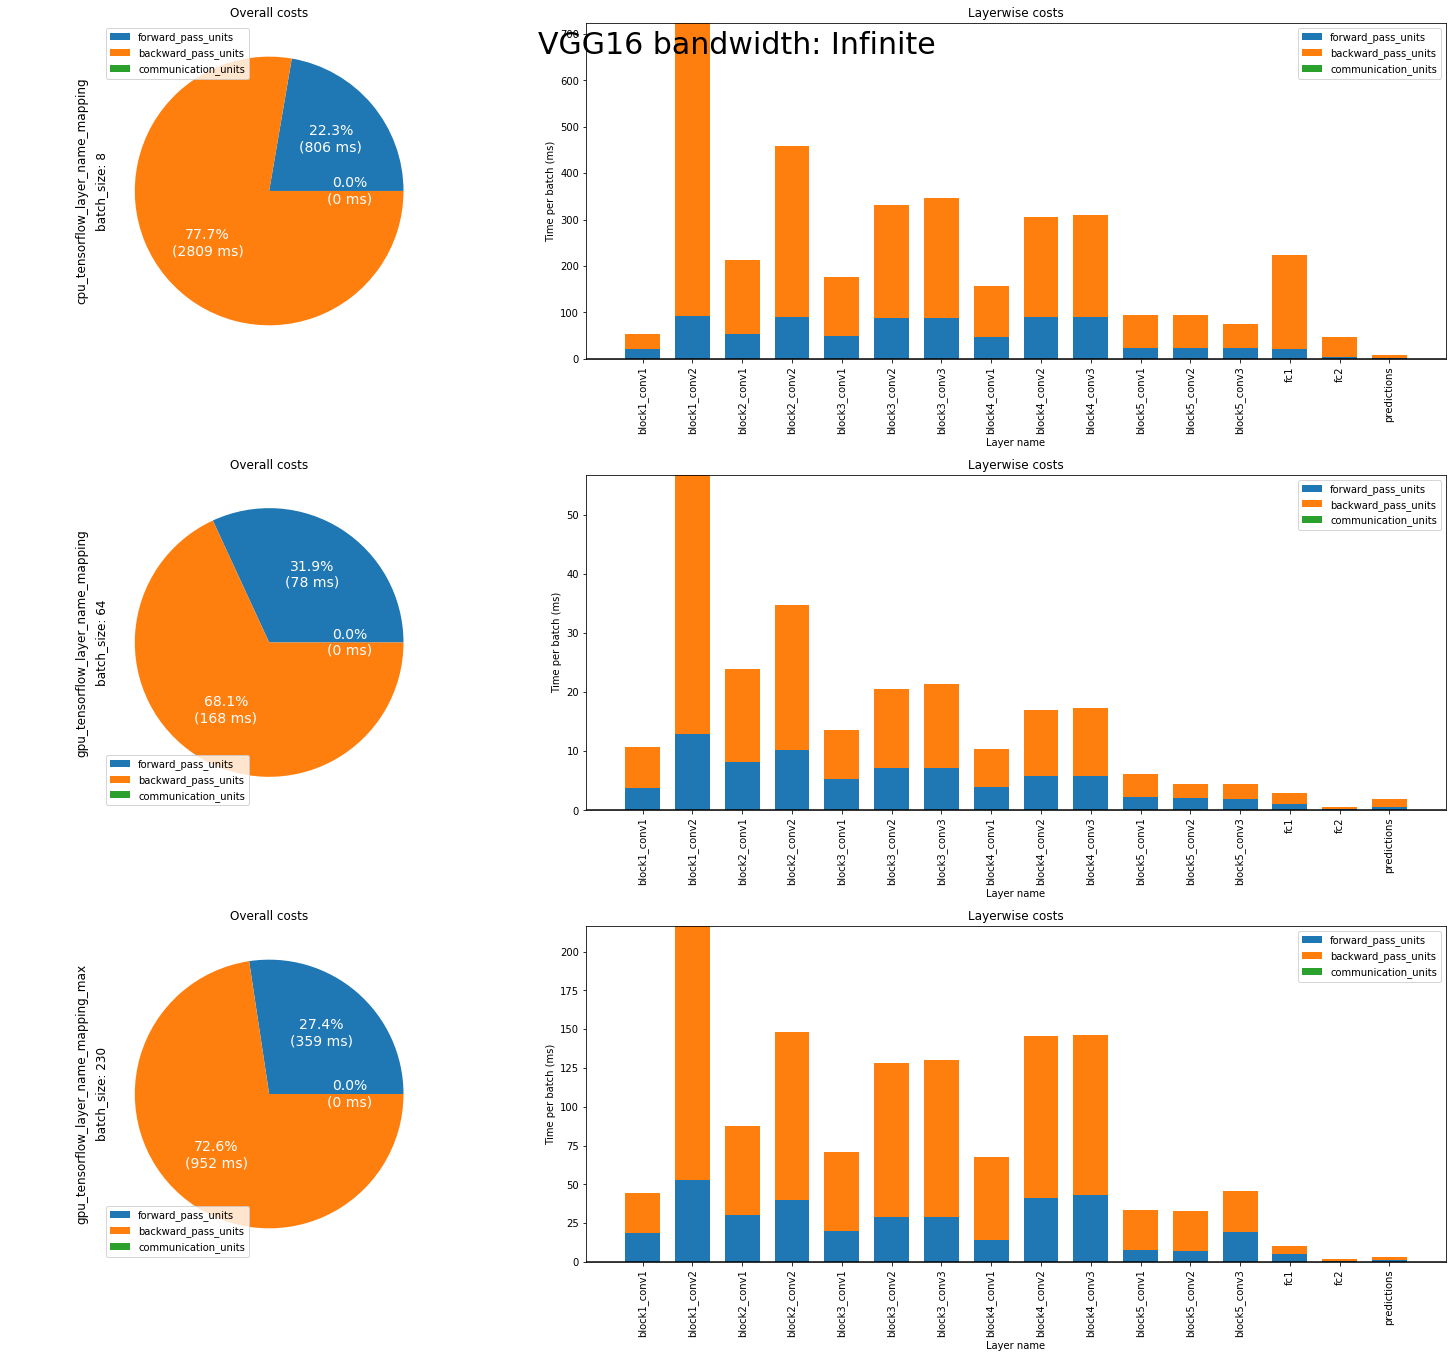

Found 107 layers
Found 107 layers
Found 107 layers


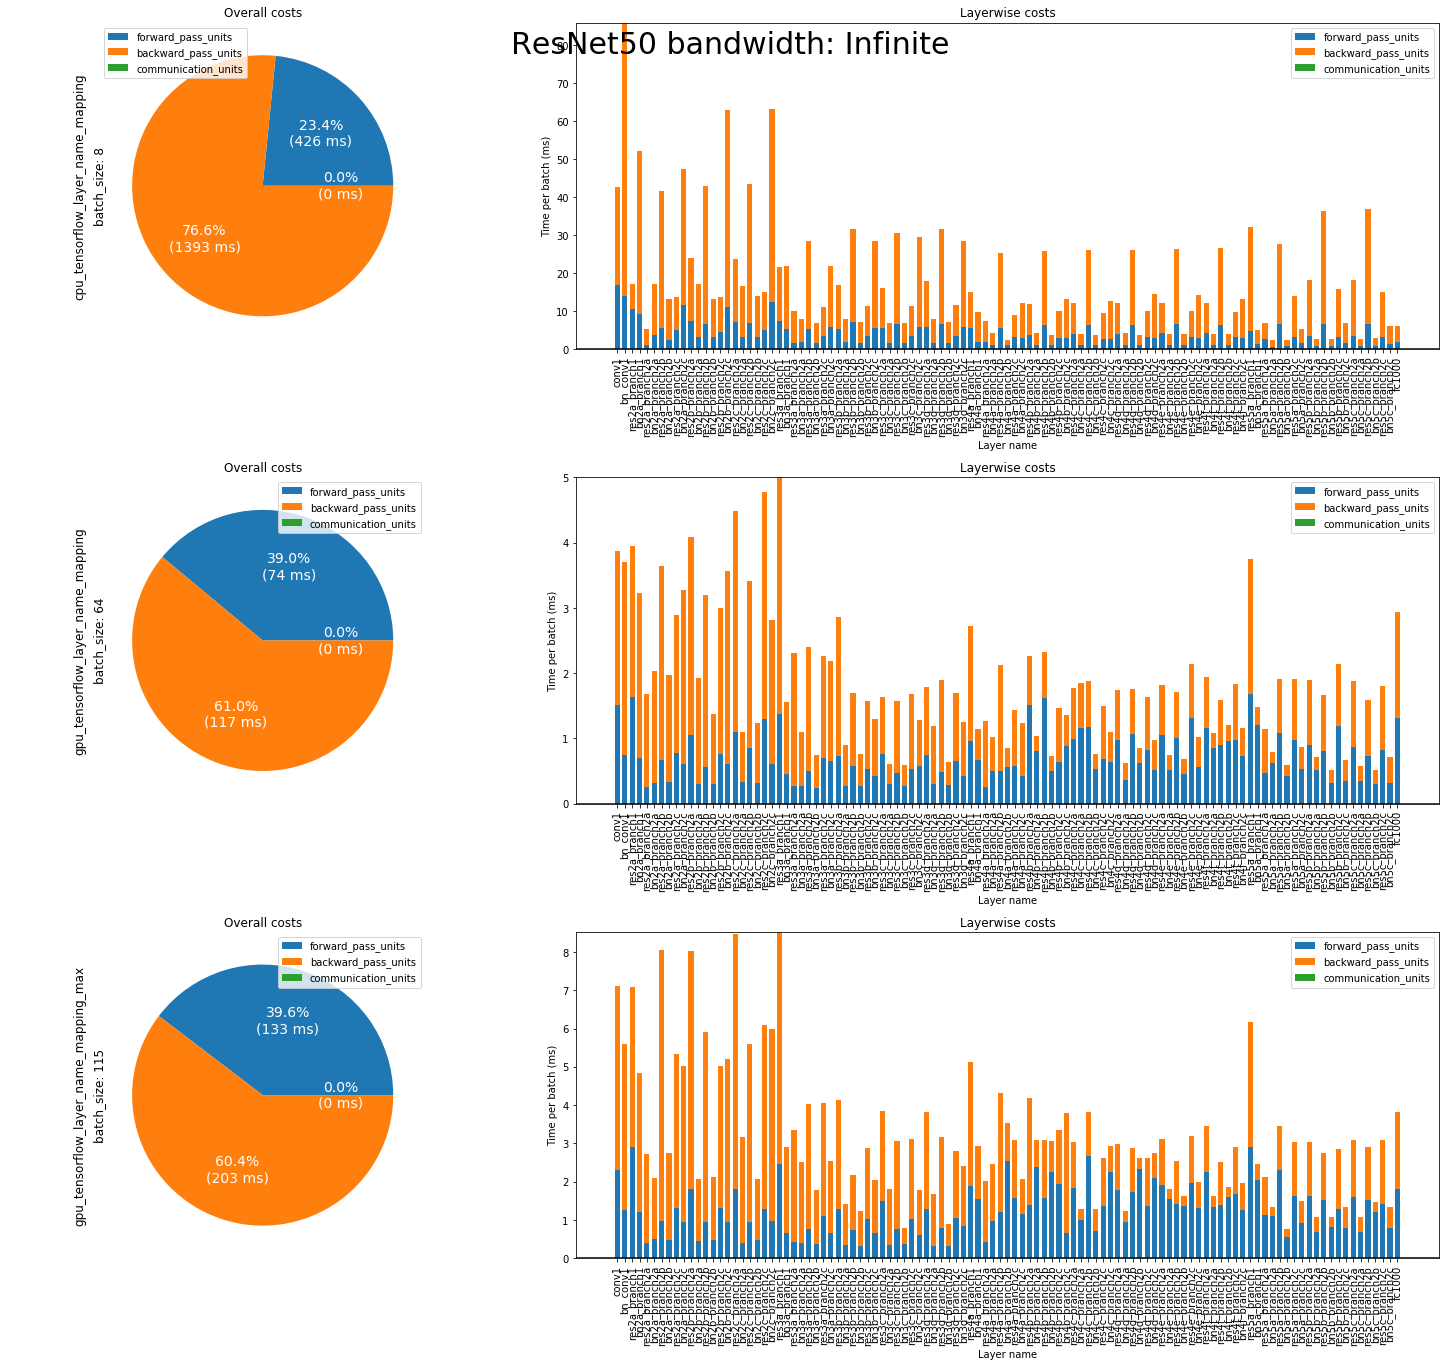

Found 189 layers
Found 189 layers
Found 189 layers


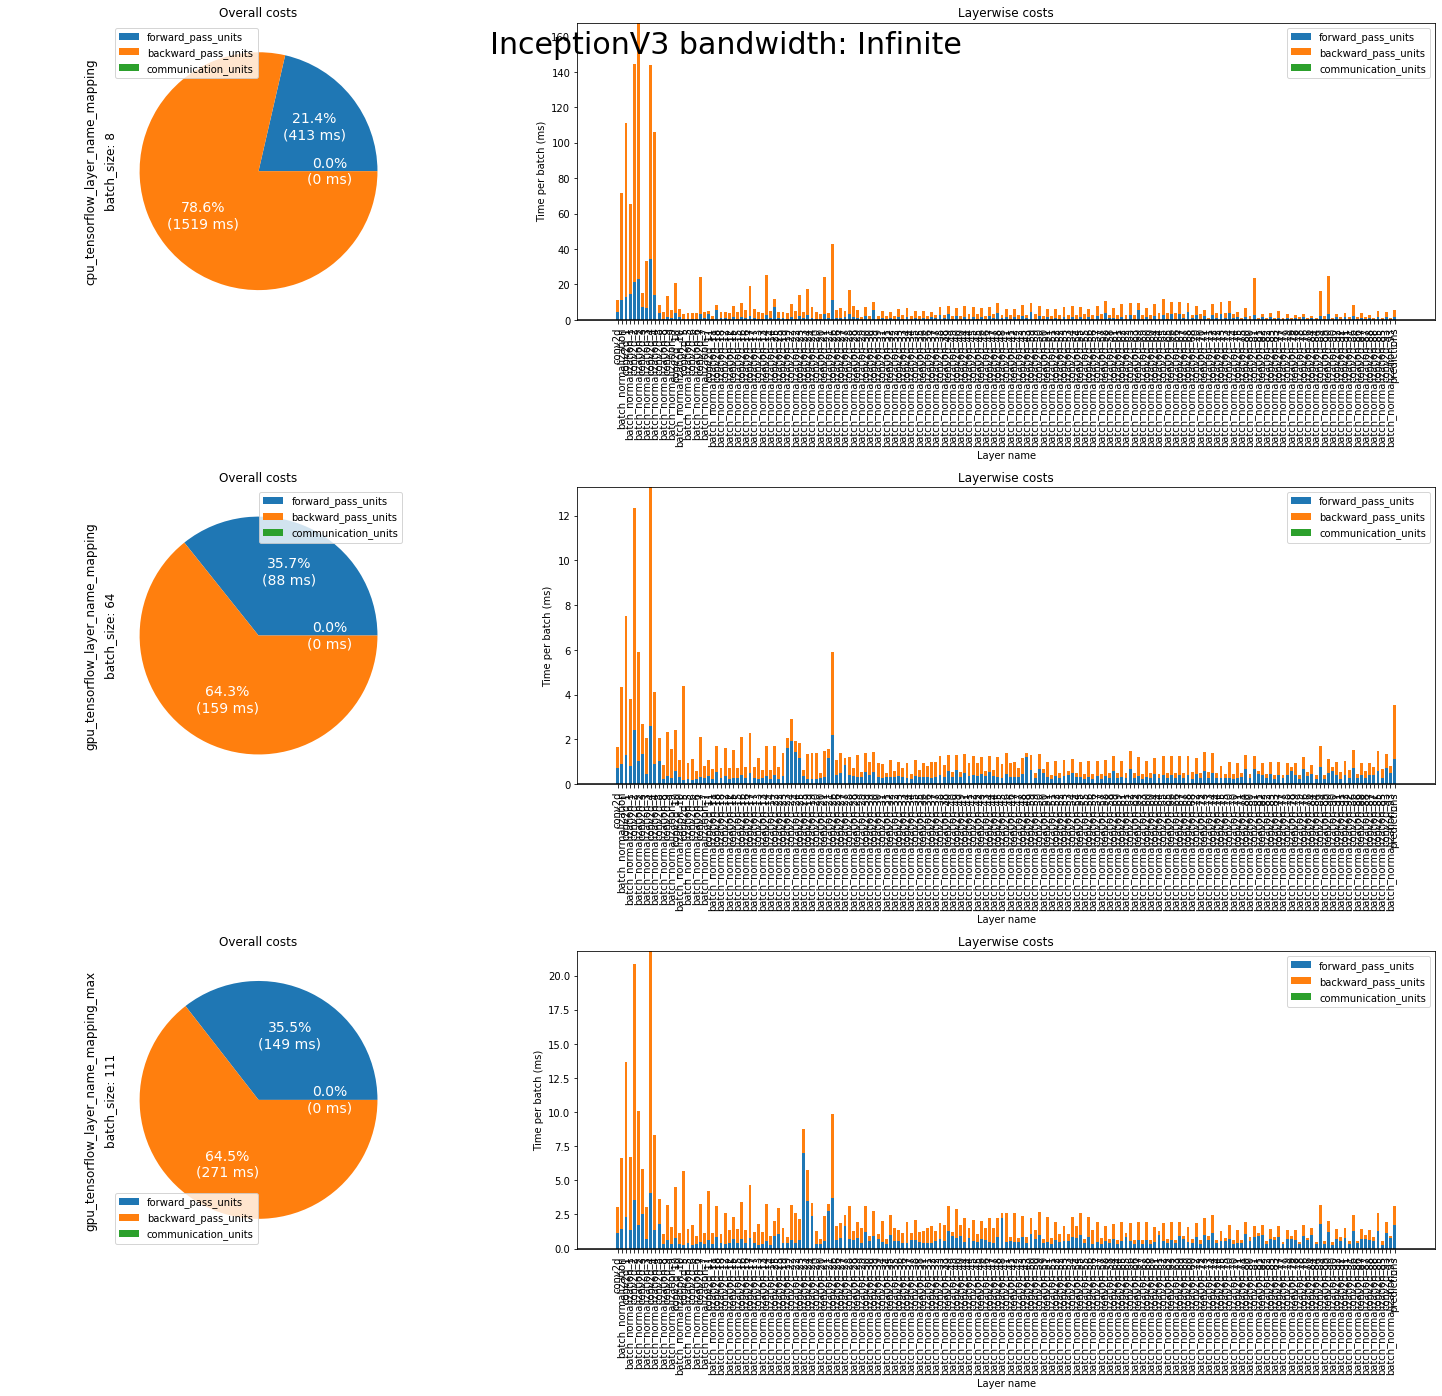

Found 242 layers
Found 242 layers
Found 242 layers


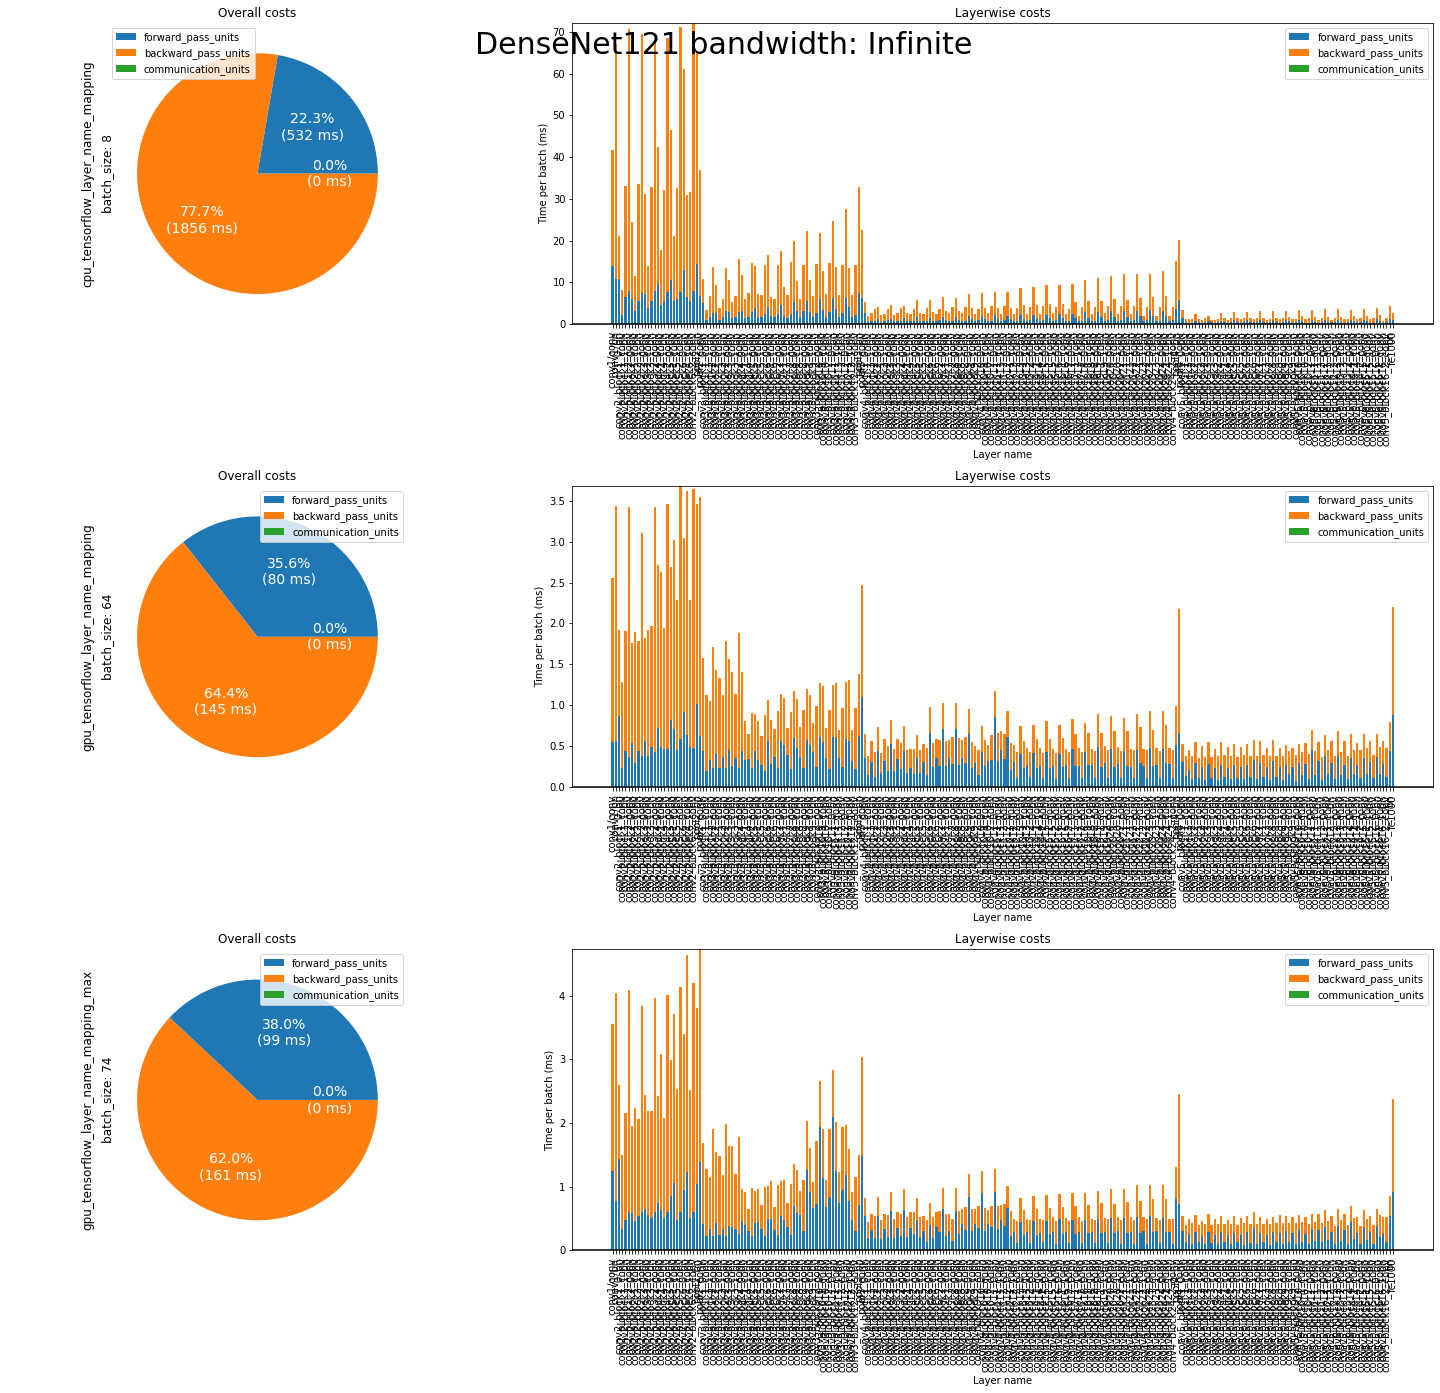

In [32]:
dag_name = "VGG16", "ResNet50", "InceptionV3", "DenseNet121"
cpu_file_names = (["VGG16_cpu_tensorflow_model_reconstruction.dag", "VGG16_cpu_tensorflow_layer_name_mapping.dag",
                   "vgg16_cpu_pytorch_module_hooks.dag"],
                  ["ResNet50_cpu_tensorflow_model_reconstruction.dag", "ResNet50_cpu_tensorflow_layer_name_mapping.dag",
                   "resnet50_cpu_pytorch_module_hooks.dag"],
                  ["InceptionV3_cpu_tensorflow_model_reconstruction.dag", "InceptionV3_cpu_tensorflow_layer_name_mapping.dag",
                   "inception_v3_cpu_pytorch_module_hooks.dag"],
                  ["DenseNet121_cpu_tensorflow_model_reconstruction.dag", "DenseNet121_cpu_tensorflow_layer_name_mapping.dag",
                   "densenet121_cpu_pytorch_module_hooks.dag"]
                  )
gpu_file_names = (["VGG16_gpu_tensorflow_model_reconstruction.dag", "VGG16_gpu_tensorflow_layer_name_mapping.dag",
                   "vgg16_gpu_pytorch_module_hooks.dag"],
                  ["ResNet50_gpu_tensorflow_model_reconstruction.dag", "ResNet50_gpu_tensorflow_layer_name_mapping.dag",
                   "resnet50_gpu_pytorch_module_hooks.dag"],
                  ["InceptionV3_gpu_tensorflow_model_reconstruction.dag", "InceptionV3_gpu_tensorflow_layer_name_mapping.dag",
                   "inception_v3_gpu_pytorch_module_hooks.dag"],
                  ["DenseNet121_gpu_tensorflow_model_reconstruction.dag", "DenseNet121_gpu_tensorflow_layer_name_mapping.dag",
                   "densenet121_gpu_pytorch_module_hooks.dag"]
                  )
lnm_file_names = [["VGG16_cpu_tensorflow_layer_name_mapping.dag", "VGG16_gpu_tensorflow_layer_name_mapping.dag",
                   "VGG16_gpu_tensorflow_layer_name_mapping_max.dag"],
                 ["ResNet50_cpu_tensorflow_layer_name_mapping.dag", "ResNet50_gpu_tensorflow_layer_name_mapping.dag",
                  "ResNet50_gpu_tensorflow_layer_name_mapping_max.dag"],
                 ["InceptionV3_cpu_tensorflow_layer_name_mapping.dag", "InceptionV3_gpu_tensorflow_layer_name_mapping.dag",
                   "InceptionV3_gpu_tensorflow_layer_name_mapping_max.dag"],
                 ["DenseNet121_cpu_tensorflow_layer_name_mapping.dag", "DenseNet121_gpu_tensorflow_layer_name_mapping.dag",
                   "DenseNet121_gpu_tensorflow_layer_name_mapping_max.dag"]]
with PdfPages("layer_name_mapping_dag_visualization.pdf") as pdf:
    for dag_name, dag_file_names in zip(dag_name, lnm_file_names):
        dags = dict()
        for file_name in dag_file_names:
            with open("dags/{}".format(file_name)) as file:
                dag = deserialize_dag(file.read())
                #graph_dag(dag)
                dags[file_name] = dag
        title = "{} bandwidth: Infinite".format(dag_name, network_rate, network_unit)
        f = plot_dags(dags, title, scaling_factors=scaling, unify_y_axis=False)
        pdf.savefig(f)